# Perturbation Analysis for Flow Matching Model
## Focus on HbA1c and Steps Features

This notebook performs counterfactual perturbation analysis on the flow matching model,
with special focus on HbA1c (covariate) and steps (time series channel) perturbations.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from scipy import stats
from tqdm import tqdm
import warnings
import random
from copy import deepcopy
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.7.0+cu128


In [2]:
# Import project modules
import sys
import os
import glob
import re
sys.path.append('/home/yl2428/Time-LLM')

from data_provider_pretrain.data_factory import data_provider
from models.time_series_flow_matching_model import TimeSeriesFlowMatchingModel
from models.model9_NS_transformer.ns_models.ns_Transformer import Model as NSTransformer
import argparse

In [3]:
# Define channel names for the 9 glucose time-series features
CHANNEL_NAMES = [
    'bolus',           # 0: Insulin bolus
    'basal',           # 1: Basal insulin rate
    'heart_rate',      # 2: Heart rate
    'steps',           # 3: Step count
    'sleep',           # 4: Sleep quality/duration
    'fat_g',           # 5: Fat intake (grams)
    'protein_g',       # 6: Protein intake (grams)
    'carbohydrates_g', # 7: Carbohydrate intake (grams)
    'glucose'          # 8: Glucose level (target)
]

# Channel indices
STEPS_CHANNEL_INDEX = 3
GLUCOSE_CHANNEL_INDEX = 8
HR_CHANNEL_INDEX = 2

# Scaling parameters for steps (from diffusion_analysis.ipynb)
STEPS_SCALE = 4062.666
STEPS_OFFSET = 2283.476
HR_SCALE = 52.3695
HR_OFFSET = 68.4355

print(f"Defined {len(CHANNEL_NAMES)} channels")
for i, name in enumerate(CHANNEL_NAMES):
    print(f"  {i}: {name}")

Defined 9 channels
  0: bolus
  1: basal
  2: heart_rate
  3: steps
  4: sleep
  5: fat_g
  6: protein_g
  7: carbohydrates_g
  8: glucose


In [4]:
# Configuration from flow_stage_feature_importance.py
class DotDict(dict):
    """A dictionary that supports both dot notation and dictionary access."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

# Flow matching configuration (exact from feature_importance_analysis.ipynb)
flow_matching_config = DotDict({
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_Transformer",
    "precision": "32",
    "generative_model": "flow_matching",
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "output_Junt_16_3.csv",
    "data_path_pretrain": "output_Junt_16_3.csv",
    "features": "MS",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/home/yl2428/checkpoints",
    "log_dir": "/home/yl2428/logs",
    "seq_len": 72,
    "label_len": 32,
    "pred_len": 48,
    "seasonal_patterns": "Monthly",
    "stride": 1,
    "enc_in": 9,
    "dec_in": 9,
    "c_out": 9,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 256,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    "vae_hidden_dim": 16,
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.995,
    "batch_size": 512,
    "eval_batch_size": 512,
    "patience": 40,
    "learning_rate": 0.0001,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    "wandb": 1,
    "wandb_group": None,
    "use_moe": 1,
    "num_experts": 8,
    "latent_len": 36,
    "top_k_experts": 4,
    "moe_layer_indices": [0, 1],
    "moe_loss_weight": 0.01,
    "log_routing_stats": 1,
    "num_universal_experts": 1,
    "universal_expert_weight": 0.3,
    "head_dropout": 0.1,
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    "k_z": 1e-2,
    "k_cond": 0.001,
    "d_z": 8,
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    "timesteps": 50,
    "ode_solver": "dopri5",
    "ode_rtol": 1e-5,
    "ode_atol": 1e-5,
    "interpolation_type": "linear",
    "expert_layers": 2,
    "loader": "modal",
    "model_comment": "none",
    "enable_context_aware": 1,
    "glucose_dropout_rate": 0.4,
    "use_contrastive_learning": 1,
    "contrastive_loss_weight": 0.1,
    "contrastive_temperature": 0.1,
    "use_momentum_encoder": 1,
    "momentum_factor": 0.999,
    "n_flow_stages": 5,
    "col_stats": {'SEX': {'COUNT': (['F', 'M'], [367, 135])}, 'RACE': {'COUNT': (['WHITE', 'NOT REPORTED', 'ASIAN', 'BLACK/AFRICAN AMERICAN', 'MULTIPLE', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE'], [459, 11, 10, 10, 8, 2, 2])}, 'ETHNIC': {'COUNT': (['Not Hispanic or Latino', 'Hispanic or Latino', 'Do not wish to answer', "Don't know"], [472, 15, 13, 2])}, 'ARMCD': {'COUNT': (['RESISTANCE', 'INTERVAL', 'AEROBIC'], [172, 167, 163])}, 'insulin modality': {'COUNT': (['CLOSED LOOP INSULIN PUMP', 'INSULIN PUMP', 'MULTIPLE DAILY INJECTIONS'], [225, 189, 88])}, 'AGE': {'MEAN': 36.655378486055774, 'STD': 13.941209833786187, 'QUANTILES': [18.0, 25.0, 33.0, 45.75, 70.0]}, 'WEIGHT': {'MEAN': 161.39940239043824, 'STD': 30.624877585598654, 'QUANTILES': [103.0, 140.0, 155.0, 179.0, 280.0]}, 'HEIGHT': {'MEAN': 66.72509960159363, 'STD': 3.505847063905933, 'QUANTILES': [58.0, 64.0, 66.0, 69.0, 77.0]}, 'HbA1c': {'MEAN': 6.642828685258964, 'STD': 0.7633658734231158, 'QUANTILES': [4.8, 6.1, 6.6, 7.1, 10.0]}, 'DIABETES_ONSET': {'MEAN': 18.72725737051793, 'STD': 11.889102915798386, 'QUANTILES': [0.0833, 11.0, 16.0, 24.0, 66.0]}},
    "col_names_dict": {'categorical': ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'], 'numerical': ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT']}
})

args = flow_matching_config
print(f"Configuration loaded: {args.model} with d_model={args.d_model}, batch_size={args.batch_size}")

Configuration loaded: ns_Transformer with d_model=32, batch_size=512


In [5]:
# Checkpoint loading functions
def find_best_checkpoint(base_path="/home/yl2428/logs/ns_Transformer/flow_matching/comfy-dust-243", metric="val_loss"):
    """Find the best checkpoint based on validation loss."""
    print(f"Searching for checkpoints in: {base_path}")

    checkpoint_pattern = os.path.join(base_path, "checkpoints/epoch=*-step=*-val_loss=*.ckpt/checkpoint")
    checkpoint_dirs = glob.glob(checkpoint_pattern)

    if not checkpoint_dirs:
        print("No checkpoints found!")
        return None, None, None

    best_checkpoint = None
    best_metric = float('inf')
    best_run = None

    print(f"Found {len(checkpoint_dirs)} checkpoints")

    for checkpoint_dir in checkpoint_dirs:
        pattern = r'epoch=(\d+)-step=(\d+)-val_loss=([\d.]+)\.ckpt'
        match = re.search(pattern, checkpoint_dir)

        if match:
            epoch, step, val_loss = match.groups()
            val_loss = float(val_loss)
            run_name = checkpoint_dir.split('/')[-4]

            print(f"  - {run_name}: epoch={epoch}, step={step}, val_loss={val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_checkpoint = checkpoint_dir
                best_run = run_name

    if best_checkpoint:
        print(f"\nBest checkpoint: {best_run}")
        print(f"  - Path: {best_checkpoint}")
        print(f"  - Val Loss: {best_metric:.4f}")

    return best_checkpoint, best_metric, best_run

def load_deepspeed_checkpoint(model, checkpoint_path, device):
    """Load DeepSpeed checkpoint into the model."""
    print(f"Loading DeepSpeed checkpoint from: {checkpoint_path}")

    model_states_path = os.path.join(checkpoint_path, "mp_rank_00_model_states.pt")

    if not os.path.exists(model_states_path):
        raise FileNotFoundError(f"Model states file not found: {model_states_path}")

    checkpoint = torch.load(model_states_path, map_location=device)

    if 'module' in checkpoint:
        state_dict = checkpoint['module']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    cleaned_state_dict = {}
    for key, value in state_dict.items():
        clean_key = key
        if key.startswith('_forward_module.'):
            clean_key = key.replace('_forward_module.', '')
        elif key.startswith('module.'):
            clean_key = key.replace('module.', '')

        if isinstance(value, torch.Tensor):
            value = value.to(device)

        cleaned_state_dict[clean_key] = value

    try:
        model = model.to(device)
        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)

        if missing_keys:
            print(f"Missing keys: {missing_keys[:10]}{'...' if len(missing_keys) > 10 else ''}")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys[:10]}{'...' if len(unexpected_keys) > 10 else ''}")

        print("✓ Model weights loaded successfully!")

    except Exception as e:
        print(f"Warning: Some keys couldn't be loaded: {e}")
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in cleaned_state_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)

        model = model.to(device)
        model.load_state_dict(model_dict)
        print(f"✓ Loaded {len(pretrained_dict)}/{len(cleaned_state_dict)} parameters")

    model = model.to(device)
    print(f"✓ All model components moved to {device}")

    return model

In [6]:
# Load model and data
print("Loading flow matching model and data...")

# Load data
train_data, train_loader, args = data_provider(
    args, args.data_pretrain, args.data_path_pretrain, True, 'train'
)
vali_data, vali_loader, args = data_provider(
    args, args.data_pretrain, args.data_path_pretrain, True, 'val'
)
test_data, test_loader, args = data_provider(
    args, args.data_pretrain, args.data_path_pretrain, False, 'test'
)

# Initialize model
model = TimeSeriesFlowMatchingModel(args, train_loader, vali_loader, test_loader)

# Find and load best checkpoint
checkpoint_path, best_metric, run_name = find_best_checkpoint()

if checkpoint_path:
    model = load_deepspeed_checkpoint(model, checkpoint_path, device)
    model.eval()
    print(f"✓ Model loaded from {run_name} with val_loss: {best_metric:.4f}")
else:
    print("No checkpoint found - using untrained model")
    model.eval()

print(f"Model on device: {next(model.parameters()).device}")
print("✓ Data and model loaded successfully!")

Loading flow matching model and data...
Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:45<00:00, 10.79it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:44<00:00, 10.96it/s]


Mean: [  0.84085476   0.80213351  79.40491332  32.5294183    0.24537674
   5.3128258    3.82292609   5.69710292 144.81223086]
Std: [ 1.61659338  0.60898286 19.36734307 86.98838521  0.43031035 14.4286974
 11.59240125 11.53828031 55.07849221]
Loading data into memory...


100%|██████████| 488/488 [00:45<00:00, 10.82it/s]


Searching for checkpoints in: /home/yl2428/logs/ns_Transformer/flow_matching/comfy-dust-243
Found 1 checkpoints
  - comfy-dust-243: epoch=9, step=111310, val_loss=1.0574

Best checkpoint: comfy-dust-243
  - Path: /home/yl2428/logs/ns_Transformer/flow_matching/comfy-dust-243/checkpoints/epoch=9-step=111310-val_loss=1.0574.ckpt/checkpoint
  - Val Loss: 1.0574
Loading DeepSpeed checkpoint from: /home/yl2428/logs/ns_Transformer/flow_matching/comfy-dust-243/checkpoints/epoch=9-step=111310-val_loss=1.0574.ckpt/checkpoint
✓ Model weights loaded successfully!
✓ All model components moved to cuda
✓ Model loaded from comfy-dust-243 with val_loss: 1.0574
Model on device: cuda:0
✓ Data and model loaded successfully!


## Perturbation Functions

In [33]:
from torch_frame import stype
def perturb_hba1c_covariates(batch_cov, individual_indices, percentage_change):
    """
    Perturbs HbA1c for specified individuals in the batch_cov.
    HbA1c is at index 3 of the numerical features.
    Returns a new batch_cov object with perturbations.
    """
    if stype.numerical not in batch_cov.feat_dict:
        print("No numerical features found in batch_cov.")
        return batch_cov
    
    # Clone the numerical features tensor
    original_numerical_tensor = batch_cov.feat_dict[stype.numerical]
    perturbed_numerical_tensor = original_numerical_tensor.clone()
    
    hba1c_changes = {}
    
    for idx in individual_indices:
        if 0 <= idx < perturbed_numerical_tensor.shape[0]:
            # HbA1c is at index 3
            current_hba1c = perturbed_numerical_tensor[idx, 3]
            print(current_hba1c)
            new_hba1c = current_hba1c * (1 + percentage_change / 100.0)
            print(new_hba1c)
            perturbed_numerical_tensor[idx, 3] = new_hba1c
            
            hba1c_changes[idx] = {
                'original': current_hba1c.item(),
                'perturbed': new_hba1c.item()
            }
        else:
            print(f"Warning: Index {idx} is out of bounds. Skipping.")
    
    # Create new batch_cov with perturbed values
    new_batch_cov = deepcopy(batch_cov)
    new_batch_cov.feat_dict[stype.numerical] = perturbed_numerical_tensor
    
    return new_batch_cov, hba1c_changes

def perturb_steps_time_series(batch_x, individual_indices, percentage_change, 
                             time_start=None, time_end=None):
    """
    Perturbs steps in the time series for specified individuals.
    Steps is at channel index 3.
    """
    perturbed_batch_x = batch_x.clone()
    
    if time_start is None:
        time_start = 0
    if time_end is None:
        time_end = batch_x.shape[1]
    
    steps_changes = {}
    
    for idx in individual_indices:
        if 0 <= idx < batch_x.shape[0]:
            # Extract steps series
            scaled_steps = perturbed_batch_x[idx, time_start:time_end, STEPS_CHANNEL_INDEX]
            
            # Convert to true values
            true_steps = scaled_steps * STEPS_SCALE + STEPS_OFFSET
            
            # Store original mean for comparison
            original_mean = true_steps.mean().item()
            
            # Apply perturbation
            perturbed_true_steps = true_steps * (1 + percentage_change / 100.0)
            
            # Convert back to scaled values
            new_scaled_steps = (perturbed_true_steps - STEPS_OFFSET) / STEPS_SCALE
            perturbed_batch_x[idx, time_start:time_end, STEPS_CHANNEL_INDEX] = new_scaled_steps
            
            # Also perturb heart rate proportionally (physiological correlation)
            if percentage_change != 0:
                hr_percentage_change = percentage_change * 0.3  # HR changes less than steps
                scaled_hr = perturbed_batch_x[idx, time_start:time_end, HR_CHANNEL_INDEX]
                true_hr = scaled_hr * HR_SCALE + HR_OFFSET
                perturbed_true_hr = true_hr * (1 + hr_percentage_change / 100.0)
                new_scaled_hr = (perturbed_true_hr - HR_OFFSET) / HR_SCALE
                perturbed_batch_x[idx, time_start:time_end, HR_CHANNEL_INDEX] = new_scaled_hr
            
            steps_changes[idx] = {
                'original_mean': original_mean,
                'perturbed_mean': perturbed_true_steps.mean().item(),
                'time_range': (time_start, time_end)
            }
            
            print(f"Individual {idx}: Steps mean changed from {original_mean:.0f} to {perturbed_true_steps.mean().item():.0f}")
    
    return perturbed_batch_x, steps_changes

## Run Perturbation Analysis

In [8]:
# Initialize storage for analysis results
perturbation_results = {
    'hba1c': [],
    'steps': []
}

# Get a batch for analysis
for batch_idx, batch in enumerate(test_loader):
    if batch_idx > 0:  # Just use first batch for now
        break
    
    # Unpack batch
    if len(batch) == 2:
        (batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov = batch
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_cov = None
    
    # Move to device
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    batch_cov = batch_cov.to(device)
    
    print(f"Batch shapes: x={batch_x.shape}, y={batch_y.shape}")
    print(f"Batch size: {batch_x.shape[0]}")
    
    # Store original batch
    original_batch = (batch_x, batch_y, batch_x_mark, batch_y_mark, batch_cov)
    
    break

Batch shapes: x=torch.Size([512, 72, 9]), y=torch.Size([512, 80, 9])
Batch size: 512


In [16]:
batch[1]

TensorFrame(
  num_cols=10,
  num_rows=512,
  categorical (5): ['ARMCD', 'ETHNIC', 'RACE', 'SEX', 'insulin modality'],
  numerical (5): ['AGE', 'DIABETES_ONSET', 'HEIGHT', 'HbA1c', 'WEIGHT'],
  has_target=False,
  device='cpu',
)

In [25]:
# Sample from model with original data
print("\nGenerating baseline predictions...")

def move_to_device(batch):
    (batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov = batch
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    batch_cov = batch_cov.to(device)
    return (batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov

with torch.no_grad():
    # Prepare decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)
    
    # Get predictions
    model.eval()
    model.cuda()
    # Sample multiple times for uncertainty quantification
    n_samples = 1
    baseline_samples = []
    
    for _ in tqdm(range(n_samples), desc="Sampling baseline"):
        if hasattr(model, 'sample_step'):
            # For compatibility with diffusion_analysis approach
            model.sample_outputs = []
            
            model.sample_step(move_to_device(batch), 0)
            pred = model.sample_outputs[-1]['pred']
        else:
            # Direct sampling
            pred = model.sample(batch_x, batch_x_mark, batch_y_mark, batch_cov)
        
        baseline_samples.append(pred)
    
    baseline_samples = np.stack(baseline_samples).squeeze().squeeze()
    print(f"Baseline samples shape: {baseline_samples.shape}")


Generating baseline predictions...


Sampling baseline:   0%|          | 0/1 [00:00<?, ?it/s]

Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]


Sampling baseline: 100%|██████████| 1/1 [00:32<00:00, 32.74s/it]

Baseline samples shape: (512, 100, 48)


In [24]:
baseline_samples.shape

(1, 512, 100, 48, 1)

### HbA1c Perturbation Analysis

In [39]:
# Select individuals to perturb
n_individuals = min(10, batch_x.shape[0])
individuals_to_perturb = random.sample(range(batch_x.shape[0]), n_individuals)

print(f"\n=== HbA1c Perturbation Analysis ===")
print(f"Perturbing {n_individuals} individuals: {individuals_to_perturb}")

# Different perturbation levels
hba1c_perturbation_levels = [-20, -10, 0, 10, 20]  # percentage changes
hba1c_results = {}

for perturb_level in hba1c_perturbation_levels:
    if perturb_level == 0:
        hba1c_results[perturb_level] = baseline_samples
        continue
    
    print(f"\nApplying {perturb_level}% HbA1c change...")
    
    # Perturb HbA1c
    perturbed_cov, hba1c_changes = perturb_hba1c_covariates(
        batch_cov, individuals_to_perturb, perturb_level
    )
    
    # Generate predictions with perturbed covariates
    perturbed_samples = []
    
    with torch.no_grad():
        for _ in tqdm(range(n_samples), desc=f"Sampling HbA1c {perturb_level}%"):
            # Create perturbed batch
            perturbed_batch = [(batch_x, batch_y, batch_x_mark, batch_y_mark), perturbed_cov]
            perturbed_batch = move_to_device(perturbed_batch)
            
            if hasattr(model, 'sample_step'):
                model.sample_outputs = []
                model.sample_step(perturbed_batch, 0)
                pred = model.sample_outputs[-1]['pred']
            else:
                pred = model.sample(batch_x, batch_x_mark, batch_y_mark, perturbed_cov)
            
            perturbed_samples.append(pred)
    
    hba1c_results[perturb_level] = np.stack(perturbed_samples).squeeze().squeeze()
    print(f"Samples shape: {hba1c_results[perturb_level].shape}")


=== HbA1c Perturbation Analysis ===
Perturbing 10 individuals: [60, 261, 171, 113, 220, 58, 26, 28, 219, 88]

Applying -20% HbA1c change...
tensor(5.6000, device='cuda:0')
tensor(4.4800, device='cuda:0')
tensor(6.8000, device='cuda:0')
tensor(5.4400, device='cuda:0')
tensor(6.9000, device='cuda:0')
tensor(5.5200, device='cuda:0')
tensor(8.2000, device='cuda:0')
tensor(6.5600, device='cuda:0')
tensor(6.7000, device='cuda:0')
tensor(5.3600, device='cuda:0')
tensor(5.5000, device='cuda:0')
tensor(4.4000, device='cuda:0')
tensor(8., device='cuda:0')
tensor(6.4000, device='cuda:0')
tensor(6., device='cuda:0')
tensor(4.8000, device='cuda:0')
tensor(7.9000, device='cuda:0')
tensor(6.3200, device='cuda:0')
tensor(6.4000, device='cuda:0')
tensor(5.1200, device='cuda:0')


Sampling HbA1c -20%:   0%|          | 0/1 [00:00<?, ?it/s]

Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]


Sampling HbA1c -20%: 100%|██████████| 1/1 [00:32<00:00, 32.91s/it]


Samples shape: (512, 100, 48)

Applying -10% HbA1c change...
tensor(5.6000, device='cuda:0')
tensor(5.0400, device='cuda:0')
tensor(6.8000, device='cuda:0')
tensor(6.1200, device='cuda:0')
tensor(6.9000, device='cuda:0')
tensor(6.2100, device='cuda:0')
tensor(8.2000, device='cuda:0')
tensor(7.3800, device='cuda:0')
tensor(6.7000, device='cuda:0')
tensor(6.0300, device='cuda:0')
tensor(5.5000, device='cuda:0')
tensor(4.9500, device='cuda:0')
tensor(8., device='cuda:0')
tensor(7.2000, device='cuda:0')
tensor(6., device='cuda:0')
tensor(5.4000, device='cuda:0')
tensor(7.9000, device='cuda:0')
tensor(7.1100, device='cuda:0')
tensor(6.4000, device='cuda:0')
tensor(5.7600, device='cuda:0')


Sampling HbA1c -10%:   0%|          | 0/1 [00:00<?, ?it/s]

Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]


Sampling HbA1c -10%: 100%|██████████| 1/1 [00:38<00:00, 38.45s/it]


Samples shape: (512, 100, 48)

Applying 10% HbA1c change...
tensor(5.6000, device='cuda:0')
tensor(6.1600, device='cuda:0')
tensor(6.8000, device='cuda:0')
tensor(7.4800, device='cuda:0')
tensor(6.9000, device='cuda:0')
tensor(7.5900, device='cuda:0')
tensor(8.2000, device='cuda:0')
tensor(9.0200, device='cuda:0')
tensor(6.7000, device='cuda:0')
tensor(7.3700, device='cuda:0')
tensor(5.5000, device='cuda:0')
tensor(6.0500, device='cuda:0')
tensor(8., device='cuda:0')
tensor(8.8000, device='cuda:0')
tensor(6., device='cuda:0')
tensor(6.6000, device='cuda:0')
tensor(7.9000, device='cuda:0')
tensor(8.6900, device='cuda:0')
tensor(6.4000, device='cuda:0')
tensor(7.0400, device='cuda:0')


Sampling HbA1c 10%:   0%|          | 0/1 [00:00<?, ?it/s]

Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]


Sampling HbA1c 10%: 100%|██████████| 1/1 [00:32<00:00, 32.96s/it]


Samples shape: (512, 100, 48)

Applying 20% HbA1c change...
tensor(5.6000, device='cuda:0')
tensor(6.7200, device='cuda:0')
tensor(6.8000, device='cuda:0')
tensor(8.1600, device='cuda:0')
tensor(6.9000, device='cuda:0')
tensor(8.2800, device='cuda:0')
tensor(8.2000, device='cuda:0')
tensor(9.8400, device='cuda:0')
tensor(6.7000, device='cuda:0')
tensor(8.0400, device='cuda:0')
tensor(5.5000, device='cuda:0')
tensor(6.6000, device='cuda:0')
tensor(8., device='cuda:0')
tensor(9.6000, device='cuda:0')
tensor(6., device='cuda:0')
tensor(7.2000, device='cuda:0')
tensor(7.9000, device='cuda:0')
tensor(9.4800, device='cuda:0')
tensor(6.4000, device='cuda:0')
tensor(7.6800, device='cuda:0')


Sampling HbA1c 20%:   0%|          | 0/1 [00:00<?, ?it/s]

Error in MoE logging: You must call wandb.init() before wandb.log()
Routing info shapes: [('layer_0', torch.Size([512, 8])), ('layer_1', torch.Size([512, 8]))]


Sampling HbA1c 20%: 100%|██████████| 1/1 [00:39<00:00, 39.96s/it]

Samples shape: (512, 100, 48)


(0,)
(0,)


### Steps Perturbation Analysis

In [ ]:
print(f"\n=== Steps Perturbation Analysis ===")

# Different perturbation levels for steps
steps_perturbation_levels = [-50, -25, 0, 25, 50]  # percentage changes
steps_results = {}

# Perturb last 24 time steps (representing recent activity)
time_start = max(0, batch_x.shape[1] - 24)
time_end = batch_x.shape[1]

for perturb_level in steps_perturbation_levels:
    if perturb_level == 0:
        steps_results[perturb_level] = baseline_samples
        continue
    
    print(f"\nApplying {perturb_level}% steps change (time {time_start}-{time_end})...")
    
    # Perturb steps in time series
    perturbed_x, steps_changes = perturb_steps_time_series(
        batch_x, individuals_to_perturb, perturb_level, time_start, time_end
    )
    
    # Generate predictions with perturbed time series
    perturbed_samples = []
    
    with torch.no_grad():
        for _ in tqdm(range(n_samples), desc=f"Sampling steps {perturb_level}%"):
            # Create perturbed batch
            perturbed_batch = [(perturbed_x, batch_y, batch_x_mark, batch_y_mark), batch_cov]
            
            if hasattr(model, 'sample_step'):
                model.sample_outputs = []
                model.sample_step(perturbed_batch, 0)
                pred = model.sample_outputs[-1]['pred']
            else:
                pred = model.sample(perturbed_x, batch_x_mark, batch_y_mark, batch_cov)
            
            perturbed_samples.append(pred.cpu().numpy())
    
    steps_results[perturb_level] = np.stack(perturbed_samples)
    print(f"Samples shape: {steps_results[perturb_level].shape}")

## Visualization and Analysis

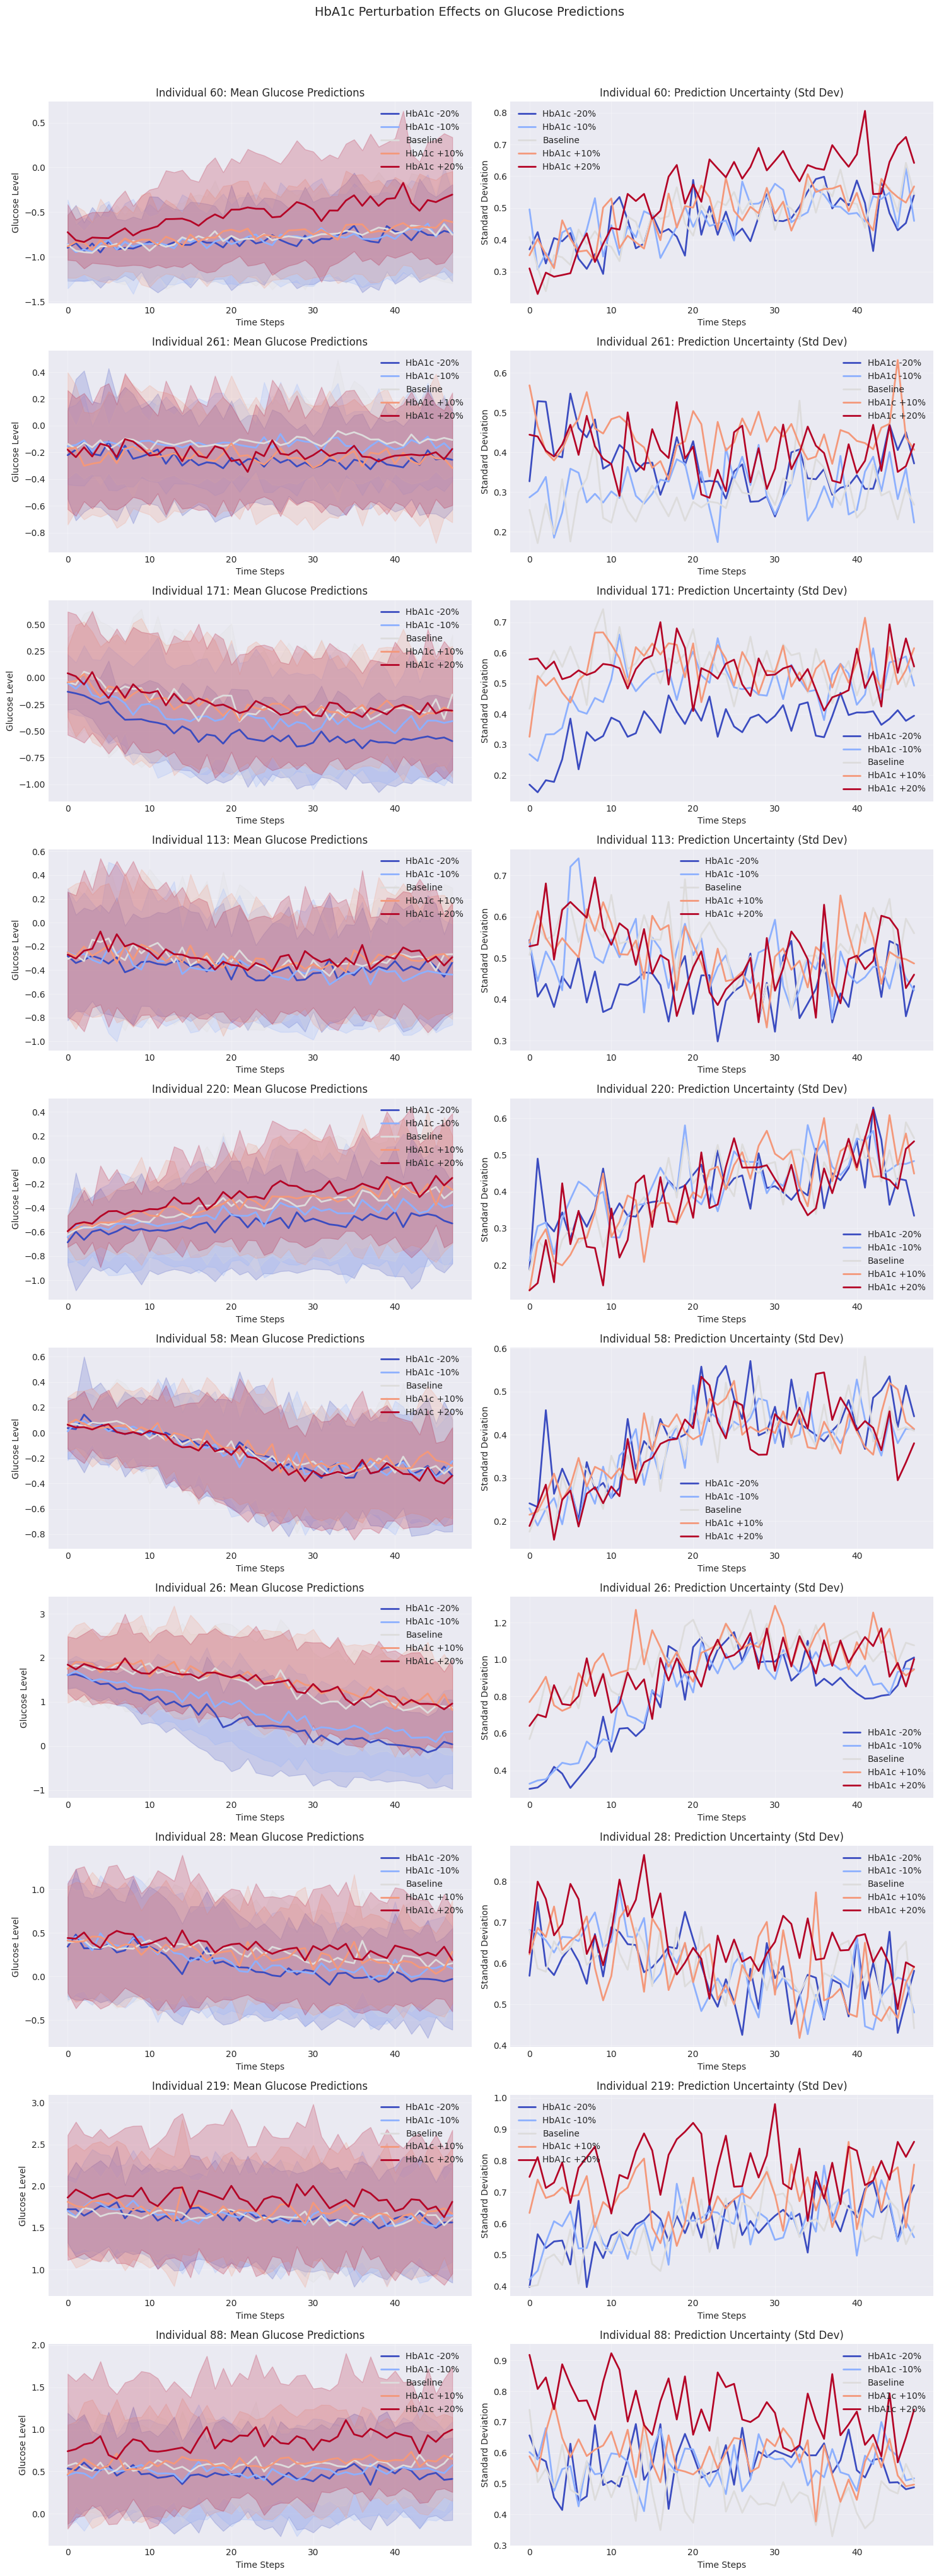

In [43]:
# Visualization of perturbation effects on glucose predictions
%matplotlib inline
def plot_perturbation_effects(results_dict, individuals, feature_name, channel_idx=GLUCOSE_CHANNEL_INDEX):
    """
    Plot the effects of perturbations on glucose predictions.
    """
    n_individuals = min(10, len(individuals))  # Plot up to 3 individuals
    fig, axes = plt.subplots(n_individuals, 2, figsize=(15, 4*n_individuals))
    
    if n_individuals == 1:
        axes = axes.reshape(1, -1)
    
    # Color map for different perturbation levels
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(results_dict)))
    
    for idx_plot, individual_idx in enumerate(individuals[:n_individuals]):
        # Plot mean predictions
        ax_mean = axes[idx_plot, 0]
        ax_std = axes[idx_plot, 1]
        
        for i, (perturb_level, samples) in enumerate(sorted(results_dict.items())):
            # Extract glucose channel predictions for this individual
            # Shape: [n_samples, pred_len]
            if samples.ndim == 4:  # [n_samples, batch, pred_len, channels]
                individual_preds = samples[:, individual_idx, :, channel_idx]
            else:  # [n_samples, batch, pred_len]
                individual_preds = samples[individual_idx, :, :]
            
            mean_pred = individual_preds.mean(axis=0)
            std_pred = individual_preds.std(axis=0)
            
            time_steps = np.arange(len(mean_pred))
            
            # Plot mean
            label = f"{feature_name} {perturb_level:+d}%" if perturb_level != 0 else "Baseline"
            ax_mean.plot(time_steps, mean_pred, label=label, color=colors[i], linewidth=2)
            ax_mean.fill_between(time_steps, mean_pred - std_pred, mean_pred + std_pred, 
                                alpha=0.2, color=colors[i])
            
            # Plot uncertainty (std)
            ax_std.plot(time_steps, std_pred, label=label, color=colors[i], linewidth=2)
        
        # Formatting
        ax_mean.set_title(f'Individual {individual_idx}: Mean Glucose Predictions')
        ax_mean.set_xlabel('Time Steps')
        ax_mean.set_ylabel('Glucose Level')
        ax_mean.legend(loc='best')
        ax_mean.grid(True, alpha=0.3)
        
        ax_std.set_title(f'Individual {individual_idx}: Prediction Uncertainty (Std Dev)')
        ax_std.set_xlabel('Time Steps')
        ax_std.set_ylabel('Standard Deviation')
        ax_std.legend(loc='best')
        ax_std.grid(True, alpha=0.3)
    
    plt.suptitle(f'{feature_name} Perturbation Effects on Glucose Predictions', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

# Plot HbA1c perturbation effects
fig_hba1c = plot_perturbation_effects(hba1c_results, individuals_to_perturb, "HbA1c")
plt.show()

# # Plot Steps perturbation effects
# fig_steps = plot_perturbation_effects(steps_results, individuals_to_perturb, "Steps")
# plt.show()

In [50]:
# Quantitative analysis of perturbation effects
def analyze_perturbation_impact(results_dict, individuals, feature_name, channel_idx=GLUCOSE_CHANNEL_INDEX):
    """
    Compute statistics on how perturbations affect predictions.
    """
    baseline = results_dict[0]
    
    impact_stats = []
    
    for perturb_level in sorted(results_dict.keys()):
        if perturb_level == 0:
            continue
        
        perturbed = results_dict[perturb_level]
        
        for individual_idx in individuals:
            # Extract predictions
            if baseline.ndim == 4:
                baseline_preds = baseline[individual_idx, :, :, channel_idx]
                perturbed_preds = perturbed[individual_idx, :, :, channel_idx]
            else:
                baseline_preds = baseline[individual_idx, :, :]
                perturbed_preds = perturbed[individual_idx, :, :]
            
            # Compute statistics
            mean_baseline = baseline_preds.mean()
            mean_perturbed = perturbed_preds.mean()
            mean_change = mean_perturbed - mean_baseline
            percent_change = (mean_change / mean_baseline) * 100
            
            std_baseline = baseline_preds.std()
            std_perturbed = perturbed_preds.std()
            std_change = std_perturbed - std_baseline
            
            # Peak changes
            max_change = (perturbed_preds.mean(axis=0) - baseline_preds.mean(axis=0)).max()
            min_change = (perturbed_preds.mean(axis=0) - baseline_preds.mean(axis=0)).min()
            
            impact_stats.append({
                'feature': feature_name,
                'perturbation': perturb_level,
                'individual': individual_idx,
                'mean_change': mean_change,
                'percent_change': percent_change,
                'std_change': std_change,
                'max_change': max_change,
                'min_change': min_change
            })
    
    return pd.DataFrame(impact_stats)

# Analyze HbA1c perturbation impact
hba1c_impact = analyze_perturbation_impact(hba1c_results, individuals_to_perturb, "HbA1c")
print("\n=== HbA1c Perturbation Impact Summary ===")
print(hba1c_impact.groupby('perturbation')[['mean_change', 'percent_change', 'std_change']].mean())

# # Analyze Steps perturbation impact
# steps_impact = analyze_perturbation_impact(steps_results, individuals_to_perturb, "Steps")
# print("\n=== Steps Perturbation Impact Summary ===")
# print(steps_impact.groupby('perturbation')[['mean_change', 'percent_change', 'std_change']].mean())


=== HbA1c Perturbation Impact Summary ===
              mean_change  percent_change  std_change
perturbation                                         
-20             -0.165822       16.217573   -0.020777
-10             -0.100062        2.907172   -0.011829
 10              0.017968        8.213370    0.032226
 20              0.089301       12.639230    0.059629



=== HbA1c Perturbation Analysis - Most Impacted Individual ===
Most impacted individual: 26 with -0.76 absolute mean change at -20% HbA1c

Data structure check:
  batch_x shape: torch.Size([512, 72, 9])
  batch_y shape: torch.Size([512, 80, 9])
  seq_len: 72, label_len: 32, pred_len: 48
  batch_y total length: 80 = label_len(32) + pred_len(48)

Plotting individual 26 with largest HbA1c impact...


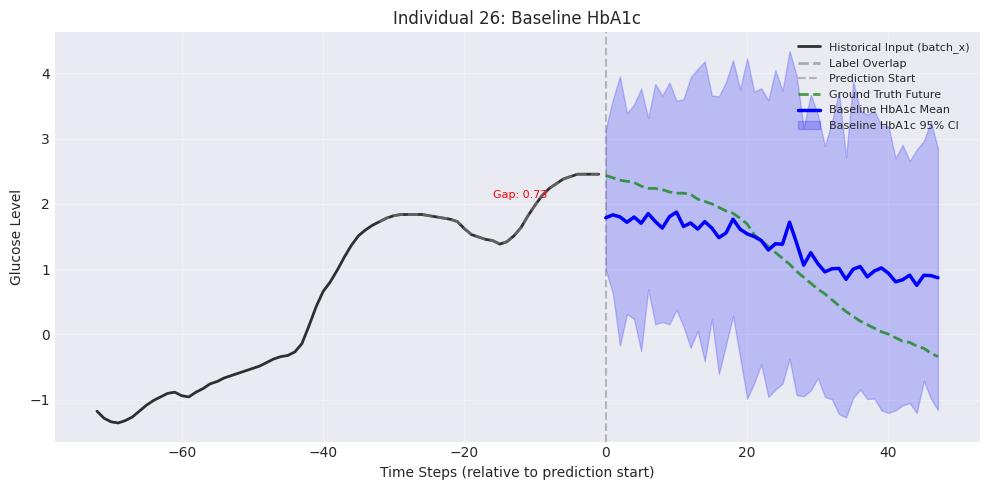

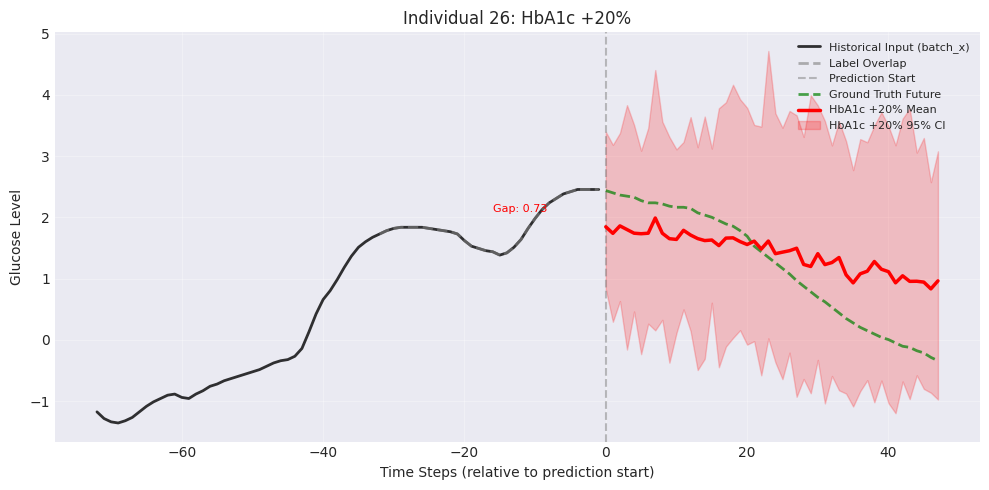

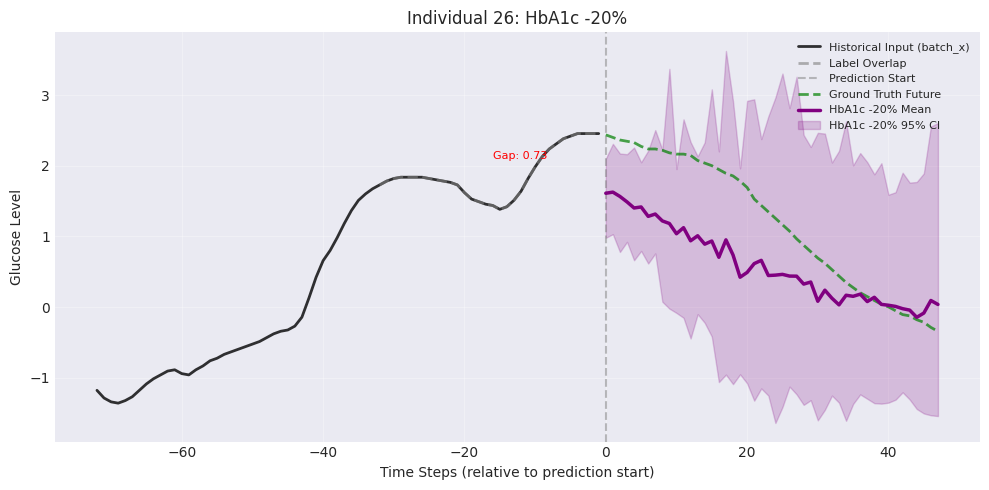


=== Steps Perturbation Analysis - Most Impacted Individual ===


NameError: name 'steps_results' is not defined

In [54]:
# Enhanced visualization with history - single individual plot
def plot_individual_with_history(samples, individual_idx, batch_x_orig, batch_y_orig, 
                                 label, color='blue', channel_idx=GLUCOSE_CHANNEL_INDEX):
    """
    Plot a single individual's predictions with historical context.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    # Get historical data
    history = batch_x_orig[individual_idx, :, channel_idx].cpu().numpy()
    
    # Get the full batch_y which includes label_len overlap + pred_len future
    full_batch_y = batch_y_orig[individual_idx, :, channel_idx].cpu().numpy()
    
    # The label portion overlaps with the end of history
    label_portion = full_batch_y[:args.label_len]
    true_future = full_batch_y[args.label_len:]  # Only the prediction portion
    
    # Create time axis
    seq_len = len(history)
    pred_len = args.pred_len
    
    # Time points
    time_history = np.arange(-seq_len, 0)
    time_label = np.arange(-args.label_len, 0)  # Overlap region
    time_pred = np.arange(0, pred_len)
    
    # Extract predictions (these are for the pred_len portion only)
    if samples.ndim == 4:
        preds = samples[individual_idx, :, :, channel_idx]
    elif samples.ndim == 3:
        preds = samples[individual_idx, :, :]
    else:
        preds = samples[individual_idx, :]
    
    # Ensure we have the right shape for statistics
    if preds.ndim == 1:
        preds = preds.reshape(1, -1)
    
    # Compute statistics
    mean_pred = preds.mean(axis=0)
    ci_lower = np.percentile(preds, 2.5, axis=0)
    ci_upper = np.percentile(preds, 97.5, axis=0)
    
    # Plot historical data
    ax.plot(time_history, history, 'k-', label='Historical Input (batch_x)', linewidth=2, alpha=0.8)
    
    # Plot the label portion (overlap) to show continuity
    ax.plot(time_label, label_portion, 'gray', label='Label Overlap', linewidth=2, alpha=0.6, linestyle='--')
    
    # Mark prediction start
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Prediction Start')
    
    # Plot ground truth future
    ax.plot(time_pred, true_future, 'g--', label='Ground Truth Future', linewidth=2, alpha=0.7)
    
    # Plot predictions
    ax.plot(time_pred, mean_pred, color=color, label=f'{label} Mean', linewidth=2.5)
    ax.fill_between(time_pred, ci_lower, ci_upper, 
                    color=color, alpha=0.2, label=f'{label} 95% CI')
    
    # Add text annotation for continuity check
    gap = history[-1] - label_portion[0] if len(label_portion) > 0 else 0
    if abs(gap) > 0.1:  # If there's a noticeable gap
        ax.annotate(f'Gap: {gap:.2f}', 
                   xy=(-args.label_len/2, (history[-1] + label_portion[0])/2),
                   fontsize=8, color='red')
    
    # Formatting
    ax.set_title(f'Individual {individual_idx}: {label}')
    ax.set_xlabel('Time Steps (relative to prediction start)')
    ax.set_ylabel('Glucose Level')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Find individual with largest absolute mean change (not percent change)
def find_most_impacted_individual(impact_df, perturbation_level):
    """
    Find the individual with the largest absolute mean change for a given perturbation level.
    """
    subset = impact_df[impact_df['perturbation'] == perturbation_level]
    if len(subset) == 0:
        return None
    
    # Find individual with maximum absolute mean change (not percent change)
    max_impact_idx = subset['mean_change'].abs().idxmax()
    most_impacted = subset.loc[max_impact_idx]
    
    return most_impacted

# Plot comparison for most impacted individual
def plot_perturbation_comparison(results_dict, impact_df, batch_x, batch_y, feature_name):
    """
    Plot baseline, +20%, and -20% perturbations for the most impacted individual.
    """
    # Find most impacted individuals for positive and negative perturbations
    most_impacted_pos = find_most_impacted_individual(impact_df, 20)
    most_impacted_neg = find_most_impacted_individual(impact_df, -20)
    
    if most_impacted_pos is None or most_impacted_neg is None:
        print("Could not find impact data for +20% and -20% perturbations")
        return None, None, None, None
    
    # Choose the individual with larger absolute mean change
    if abs(most_impacted_pos['mean_change']) > abs(most_impacted_neg['mean_change']):
        individual_idx = int(most_impacted_pos['individual'])
        max_impact = most_impacted_pos['mean_change']
        print(f"Most impacted individual: {individual_idx} with {max_impact:.2f} absolute mean change at +20% {feature_name}")
    else:
        individual_idx = int(most_impacted_neg['individual'])
        max_impact = most_impacted_neg['mean_change']
        print(f"Most impacted individual: {individual_idx} with {max_impact:.2f} absolute mean change at -20% {feature_name}")
    
    # Print debug info about the data structure
    print(f"\nData structure check:")
    print(f"  batch_x shape: {batch_x.shape}")
    print(f"  batch_y shape: {batch_y.shape}")
    print(f"  seq_len: {args.seq_len}, label_len: {args.label_len}, pred_len: {args.pred_len}")
    print(f"  batch_y total length: {batch_y.shape[1]} = label_len({args.label_len}) + pred_len({args.pred_len})")
    
    # Create three separate plots
    print(f"\nPlotting individual {individual_idx} with largest {feature_name} impact...")
    
    # Plot 1: Baseline
    fig_baseline = plot_individual_with_history(
        results_dict[0], individual_idx, batch_x, batch_y,
        f"Baseline {feature_name}", color='blue'
    )
    
    # Plot 2: +20% perturbation
    fig_pos = plot_individual_with_history(
        results_dict[20], individual_idx, batch_x, batch_y,
        f"{feature_name} +20%", color='red'
    )
    
    # Plot 3: -20% perturbation
    fig_neg = plot_individual_with_history(
        results_dict[-20], individual_idx, batch_x, batch_y,
        f"{feature_name} -20%", color='purple'
    )
    
    return fig_baseline, fig_pos, fig_neg, individual_idx

# HbA1c Analysis - Find and plot most impacted individual
print("\n=== HbA1c Perturbation Analysis - Most Impacted Individual ===")
hba1c_figs = plot_perturbation_comparison(
    hba1c_results, hba1c_impact, batch_x, batch_y, "HbA1c"
)

if hba1c_figs[0] is not None:
    fig_hba1c_baseline, fig_hba1c_pos, fig_hba1c_neg, hba1c_most_impacted_idx = hba1c_figs
    plt.show()  # Shows all three plots

# Steps Analysis - Find and plot most impacted individual  
print("\n=== Steps Perturbation Analysis - Most Impacted Individual ===")

# For steps, we need to check 50% perturbations
steps_impact_extended = analyze_perturbation_impact(
    {-50: steps_results[-50], 0: steps_results[0], 50: steps_results[50]},
    individuals_to_perturb, "Steps"
)

def plot_steps_perturbation_comparison(results_dict, impact_df, batch_x, batch_y):
    """
    Plot baseline, +50%, and -50% perturbations for the most impacted individual.
    """
    # Find most impacted individuals based on absolute mean change
    most_impacted_pos = find_most_impacted_individual(impact_df, 50)
    most_impacted_neg = find_most_impacted_individual(impact_df, -50)
    
    if most_impacted_pos is None or most_impacted_neg is None:
        print("Could not find impact data for +50% and -50% perturbations")
        return None, None, None, None
    
    # Choose the individual with larger absolute mean change
    if abs(most_impacted_pos['mean_change']) > abs(most_impacted_neg['mean_change']):
        individual_idx = int(most_impacted_pos['individual'])
        max_impact = most_impacted_pos['mean_change']
        print(f"Most impacted individual: {individual_idx} with {max_impact:.2f} absolute mean change at +50% Steps")
    else:
        individual_idx = int(most_impacted_neg['individual'])
        max_impact = most_impacted_neg['mean_change']
        print(f"Most impacted individual: {individual_idx} with {max_impact:.2f} absolute mean change at -50% Steps")
    
    # Create three separate plots
    print(f"\nPlotting individual {individual_idx} with largest Steps impact...")
    
    # Plot 1: Baseline
    fig_baseline = plot_individual_with_history(
        results_dict[0], individual_idx, batch_x, batch_y,
        "Baseline Steps", color='blue'
    )
    
    # Plot 2: +50% perturbation
    fig_pos = plot_individual_with_history(
        results_dict[50], individual_idx, batch_x, batch_y,
        "Steps +50%", color='red'
    )
    
    # Plot 3: -50% perturbation
    fig_neg = plot_individual_with_history(
        results_dict[-50], individual_idx, batch_x, batch_y,
        "Steps -50%", color='purple'
    )
    
    return fig_baseline, fig_pos, fig_neg, individual_idx

steps_figs = plot_steps_perturbation_comparison(
    steps_results, steps_impact_extended, batch_x, batch_y
)

if steps_figs[0] is not None:
    fig_steps_baseline, fig_steps_pos, fig_steps_neg, steps_most_impacted_idx = steps_figs
    plt.show()  # Shows all three plots

In [ ]:
# Sensitivity analysis: correlation between perturbation magnitude and prediction change
def compute_sensitivity(results_dict, individuals, channel_idx=GLUCOSE_CHANNEL_INDEX):
    """
    Compute sensitivity of predictions to perturbations.
    """
    perturbation_levels = sorted(results_dict.keys())
    baseline = results_dict[0]
    
    sensitivities = []
    
    for individual_idx in individuals:
        mean_changes = []
        
        for level in perturbation_levels:
            if baseline.ndim == 4:
                baseline_preds = baseline[:, individual_idx, :, channel_idx]
                current_preds = results_dict[level][:, individual_idx, :, channel_idx]
            else:
                baseline_preds = baseline[:, individual_idx, :]
                current_preds = results_dict[level][:, individual_idx, :]
            
            mean_change = current_preds.mean() - baseline_preds.mean()
            mean_changes.append(mean_change)
        
        # Compute correlation
        if len(perturbation_levels) > 2:
            correlation, p_value = stats.pearsonr(perturbation_levels, mean_changes)
            slope, intercept = np.polyfit(perturbation_levels, mean_changes, 1)
            
            sensitivities.append({
                'individual': individual_idx,
                'correlation': correlation,
                'p_value': p_value,
                'sensitivity_slope': slope,
                'intercept': intercept
            })
    
    return pd.DataFrame(sensitivities)

# Compute sensitivity for HbA1c
hba1c_sensitivity = compute_sensitivity(hba1c_results, individuals_to_perturb)
print("\n=== HbA1c Sensitivity Analysis ===")
print(f"Mean correlation: {hba1c_sensitivity['correlation'].mean():.3f}")
print(f"Mean sensitivity slope: {hba1c_sensitivity['sensitivity_slope'].mean():.4f}")
print(f"Significant correlations (p<0.05): {(hba1c_sensitivity['p_value'] < 0.05).sum()}/{len(hba1c_sensitivity)}")

# Compute sensitivity for Steps
steps_sensitivity = compute_sensitivity(steps_results, individuals_to_perturb)
print("\n=== Steps Sensitivity Analysis ===")
print(f"Mean correlation: {steps_sensitivity['correlation'].mean():.3f}")
print(f"Mean sensitivity slope: {steps_sensitivity['sensitivity_slope'].mean():.4f}")
print(f"Significant correlations (p<0.05): {(steps_sensitivity['p_value'] < 0.05).sum()}/{len(steps_sensitivity)}")

In [58]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure matplotlib for publication-quality PDFs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Set matplotlib parameters for better PDF quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,  # TrueType fonts for better compatibility
    'ps.fonttype': 42,
    'text.usetex': False,  # Don't use LaTeX
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
})

# Save results
results_summary = {
    'hba1c_impact': hba1c_impact.to_dict(),
    # 'steps_impact': steps_impact.to_dict(),
    # 'hba1c_sensitivity': hba1c_sensitivity.to_dict(),
    # 'steps_sensitivity': steps_sensitivity.to_dict(),
    'config': {
        'n_samples': n_samples,
        'n_individuals': n_individuals,
        'hba1c_levels': hba1c_perturbation_levels,
        # 'steps_levels': steps_perturbation_levels,
        'model_checkpoint': checkpoint_path if checkpoint_path else 'untrained',
        'random_seed': 42
    }
}

# Save to JSON file
import json
with open('perturbation_analysis_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("\n✓ Results saved to perturbation_analysis_results.json")

# Save figures to individual PDFs and combined PDF
print("\n=== Saving Figures to PDF ===")

# Create a combined PDF with all figures
with PdfPages('perturbation_analysis_all_figures.pdf') as pdf:
    
    # Save overview figures
    if 'fig_hba1c' in locals():
        fig_hba1c.savefig('hba1c_perturbation_effects_overview.pdf', format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_hba1c, dpi=300, bbox_inches='tight')
        print("✓ Saved hba1c_perturbation_effects_overview.pdf")
        
    if 'fig_steps' in locals():
        fig_steps.savefig('steps_perturbation_effects_overview.pdf', format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_steps, dpi=300, bbox_inches='tight')
        print("✓ Saved steps_perturbation_effects_overview.pdf")
    
    # Save HbA1c most impacted individual figures
    if 'fig_hba1c_baseline' in locals():
        fig_hba1c_baseline.savefig(f'hba1c_individual_{hba1c_most_impacted_idx}_baseline.pdf', 
                                   format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_hba1c_baseline, dpi=300, bbox_inches='tight')
        print(f"✓ Saved hba1c_individual_{hba1c_most_impacted_idx}_baseline.pdf")
        
    if 'fig_hba1c_pos' in locals():
        fig_hba1c_pos.savefig(f'hba1c_individual_{hba1c_most_impacted_idx}_plus20.pdf', 
                             format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_hba1c_pos, dpi=300, bbox_inches='tight')
        print(f"✓ Saved hba1c_individual_{hba1c_most_impacted_idx}_plus20.pdf")
        
    if 'fig_hba1c_neg' in locals():
        fig_hba1c_neg.savefig(f'hba1c_individual_{hba1c_most_impacted_idx}_minus20.pdf', 
                             format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_hba1c_neg, dpi=300, bbox_inches='tight')
        print(f"✓ Saved hba1c_individual_{hba1c_most_impacted_idx}_minus20.pdf")
    
    # Save Steps most impacted individual figures
    if 'fig_steps_baseline' in locals():
        fig_steps_baseline.savefig(f'steps_individual_{steps_most_impacted_idx}_baseline.pdf', 
                                   format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_steps_baseline, dpi=300, bbox_inches='tight')
        print(f"✓ Saved steps_individual_{steps_most_impacted_idx}_baseline.pdf")
        
    if 'fig_steps_pos' in locals():
        fig_steps_pos.savefig(f'steps_individual_{steps_most_impacted_idx}_plus50.pdf', 
                             format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_steps_pos, dpi=300, bbox_inches='tight')
        print(f"✓ Saved steps_individual_{steps_most_impacted_idx}_plus50.pdf")
        
    if 'fig_steps_neg' in locals():
        fig_steps_neg.savefig(f'steps_individual_{steps_most_impacted_idx}_minus50.pdf', 
                             format='pdf', dpi=300, bbox_inches='tight')
        pdf.savefig(fig_steps_neg, dpi=300, bbox_inches='tight')
        print(f"✓ Saved steps_individual_{steps_most_impacted_idx}_minus50.pdf")
    
    # Add metadata to PDF
    d = pdf.infodict()
    d['Title'] = 'Perturbation Analysis Results'
    d['Author'] = 'Flow Matching Model Analysis'
    d['Subject'] = 'HbA1c and Steps Perturbation Effects on Glucose Predictions'
    d['Keywords'] = 'Perturbation Analysis, Glucose Prediction, Flow Matching'
    d['CreationDate'] = mpl.dates.datetime.datetime.now()

print("\n✓ All figures saved to individual PDFs")
print("✓ Combined PDF saved as 'perturbation_analysis_all_figures.pdf'")

# Also save PNG versions for quick viewing
print("\n=== Also saving PNG versions for quick viewing ===")
for fig_name, fig in [
    ('hba1c_overview', fig_hba1c) if 'fig_hba1c' in locals() else (None, None),
    ('steps_overview', fig_steps) if 'fig_steps' in locals() else (None, None),
    (f'hba1c_{hba1c_most_impacted_idx}_baseline', fig_hba1c_baseline) if 'fig_hba1c_baseline' in locals() else (None, None),
    (f'hba1c_{hba1c_most_impacted_idx}_plus20', fig_hba1c_pos) if 'fig_hba1c_pos' in locals() else (None, None),
    (f'hba1c_{hba1c_most_impacted_idx}_minus20', fig_hba1c_neg) if 'fig_hba1c_neg' in locals() else (None, None),
    (f'steps_{steps_most_impacted_idx}_baseline', fig_steps_baseline) if 'fig_steps_baseline' in locals() else (None, None),
    (f'steps_{steps_most_impacted_idx}_plus50', fig_steps_pos) if 'fig_steps_pos' in locals() else (None, None),
    (f'steps_{steps_most_impacted_idx}_minus50', fig_steps_neg) if 'fig_steps_neg' in locals() else (None, None),
]:
    if fig is not None:
        fig.savefig(f'{fig_name}.png', dpi=150, bbox_inches='tight')
        print(f"✓ Saved {fig_name}.png")

print("\n✓ All figures saved successfully in both PDF and PNG formats")


✓ Results saved to perturbation_analysis_results.json

=== Saving Figures to PDF ===
✓ Saved hba1c_perturbation_effects_overview.pdf
✓ Saved hba1c_individual_26_baseline.pdf
✓ Saved hba1c_individual_26_plus20.pdf
✓ Saved hba1c_individual_26_minus20.pdf

✓ All figures saved to individual PDFs
✓ Combined PDF saved as 'perturbation_analysis_all_figures.pdf'

=== Also saving PNG versions for quick viewing ===
✓ Saved hba1c_overview.png
✓ Saved hba1c_26_baseline.png
✓ Saved hba1c_26_plus20.png
✓ Saved hba1c_26_minus20.png

✓ All figures saved successfully in both PDF and PNG formats


## Summary

This notebook performed counterfactual perturbation analysis on the flow matching model, focusing on:

1. **HbA1c Perturbations**: Analyzed how changes in HbA1c (a long-term glucose control indicator) affect future glucose predictions
2. **Steps Perturbations**: Analyzed how changes in physical activity (steps) affect glucose predictions

Key findings are summarized in the statistics above and saved to files for further analysis.